<a href="https://colab.research.google.com/github/radhakrishnan-omotec/iris24-kiara/blob/main/Skin_Diseases_KiaraPatel_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PET SKIN DISEASE CLASSIFICATION
##Various types of Dog Skin diseases classification using CNN Model
###Author: Kiara Patel
**Abstract:**
The global prevalence of autism affecting 1 in 100 children highlights a critical issue in social communication.
Individuals on the spectrum grapple with language processing, leading to struggles in formulating responses.
25 - 30% face challenges in developing functional language skills, resulting in communication hurdles that strain relationships and impede learning.
Verbal communication difficulties lead to frustration and anxiety, affecting overall well-being.

###Image classification
This tutorial shows how to classify images of flowers using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. It demonstrates the following concepts:

####Efficiently loading a dataset off disk.
Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.
This tutorial follows a basic machine learning workflow:

**Examine and understand data<br>
Build an input pipeline<br>
Build the model<br>
Train the model<br>
Test the model<br>**

Improve the model and repeat the process

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c diabetic-retinopathy-detection

!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

In [ ]:
# Unzip the competition data
!unzip -q diabetic-retinopathy-detection.zip -d diabetic-retinopathy-detection

# Unzip the dataset
!unzip -q diabetic-retinopathy-224x224-gaussian-filtered.zip -d diabetic-retinopathy-224x224-gaussian-filtered

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#Setup
Import TensorFlow and other necessary libraries:

###Setup
Import TensorFlow and other necessary libraries:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [1]:
!git clone https://github.com/radhakrishnan-omotec/iris24-kiara.git

Cloning into 'iris24-kiara'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.79 MiB | 5.90 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download and explore the dataset
This tutorial uses a dataset of about photos of skin diease. The dataset contains five sub-directories, one per class:

**After downloading, you should now have a copy of the dataset available.**

In [5]:
import pathlib
# Define the directory path
data_dir = pathlib.Path('/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET')
# Specify the image file extensions to look for
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
# Use pathlib to find all image files in the directory and subdirectories
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
# Count the number of image files
num_images = len(image_files)
print(f"Number of images: {num_images}")

Number of images: 1200


Download and explore the dataset

In [6]:
# STEP 2: Load the folder in the connected Google Drive
import os

# Change this path to the folder you want to analyze
folder_path = '/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET'


# Check if the folder exists
if not os.path.exists(folder_path):
    raise Exception(f"The folder {folder_path} does not exist. Please check the path.")
else:
    print("Folder Loaded Successfully")

Folder Loaded Successfully


In [7]:
import pathlib
# Define the directory path
data_dir = pathlib.Path('/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET')
# Specify the image file extensions to look for
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
# Use pathlib to find all image files in the directory and subdirectories
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
# Count the number of image files
num_images = len(image_files)
print(f"Number of images: {num_images}")


Number of images: 1200


#Load data using a Keras utility
Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the Load and preprocess images tutorial.

#Create a dataset
Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1200 files belonging to 4 classes.
Using 960 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1200 files belonging to 4 classes.
Using 240 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['CLASS_1-FUNGAL_INFECTIONS', 'CLASS_2-BACTERIAL_DERMATOSIS', 'CLASS_3-HYPERSENSITIVITY_DERMATITIS', 'CLASS_4-HEALTHY_SKIN']


#Visualize the data
Here are the first nine images from the training dataset:

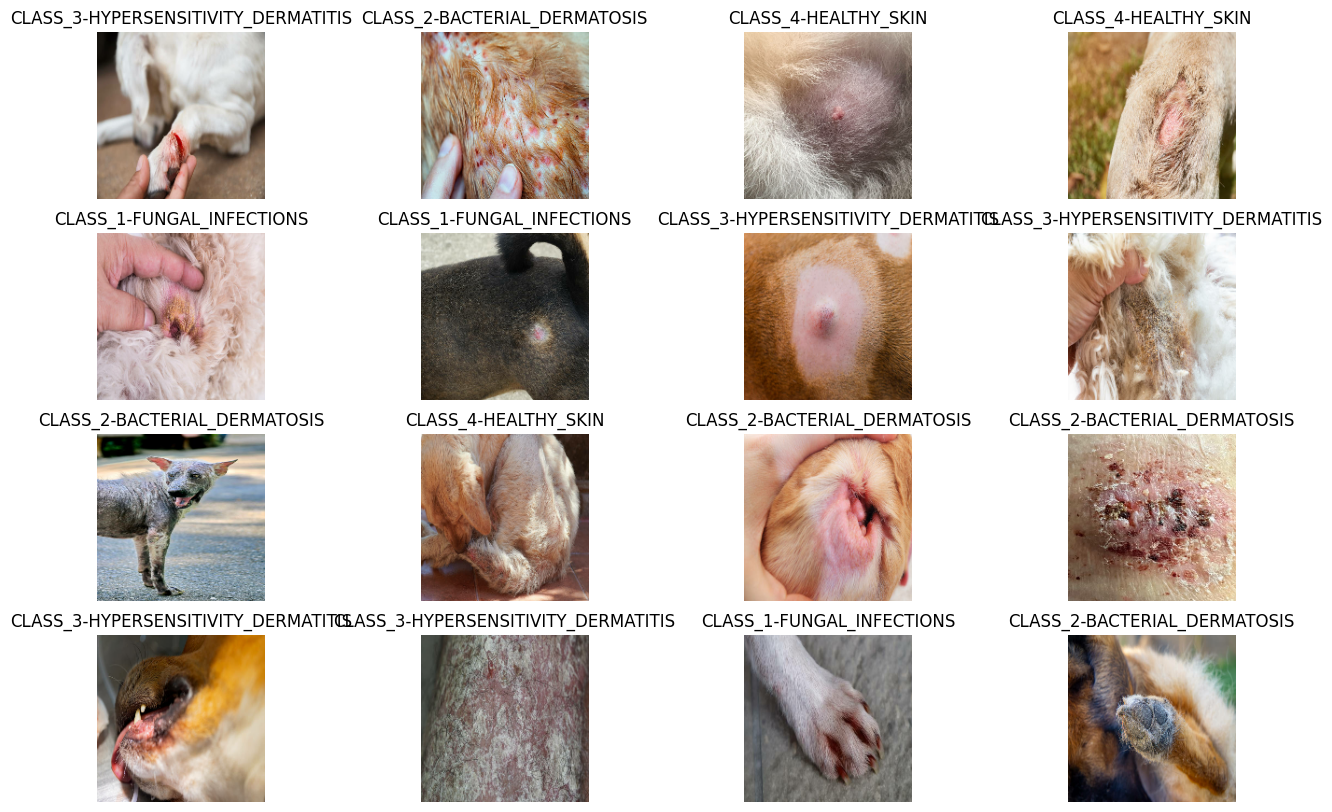

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [14]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.982746



#A basic Keras model
###Create the model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the model


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model summary

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.2449 - loss: 1.8053 - val_accuracy: 0.2125 - val_loss: 1.3879
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2534 - loss: 1.3866 - val_accuracy: 0.2125 - val_loss: 1.3879
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2658 - loss: 1.3858 - val_accuracy: 0.2125 - val_loss: 1.3892
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2487 - loss: 1.3866 - val_accuracy: 0.2125 - val_loss: 1.3900
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2479 - loss: 1.3856 - val_accuracy: 0.2125 - val_loss: 1.3923
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2751 - loss: 1.3854 - val_accuracy: 0.2125 - val_loss: 1.3935
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3045 - loss: 1.3823 - val_accuracy: 0.1958 - val_loss: 1.3931
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2238 - loss: 1.3867 - val_accuracy: 0.1625 - val_loss:


#Visualize training results
Create plots of the loss and accuracy on the training and validation sets:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

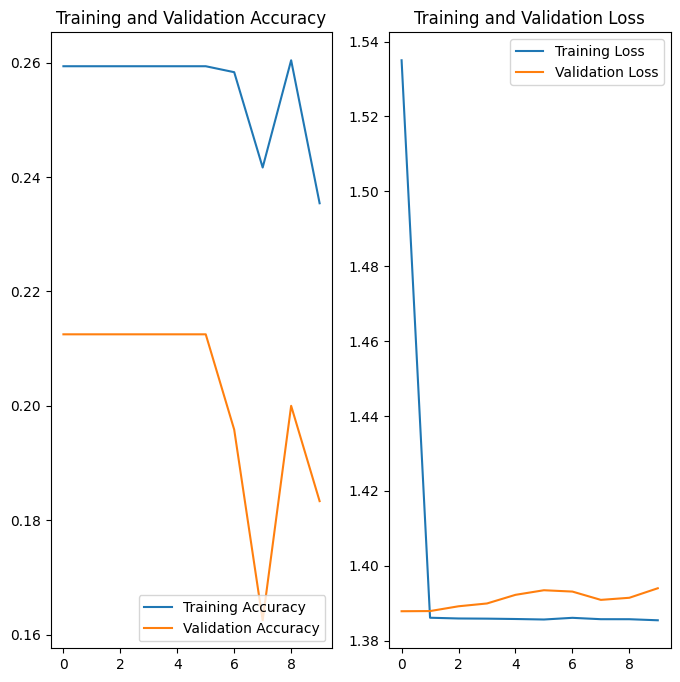

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfitting


#Data augmentation

In [27]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

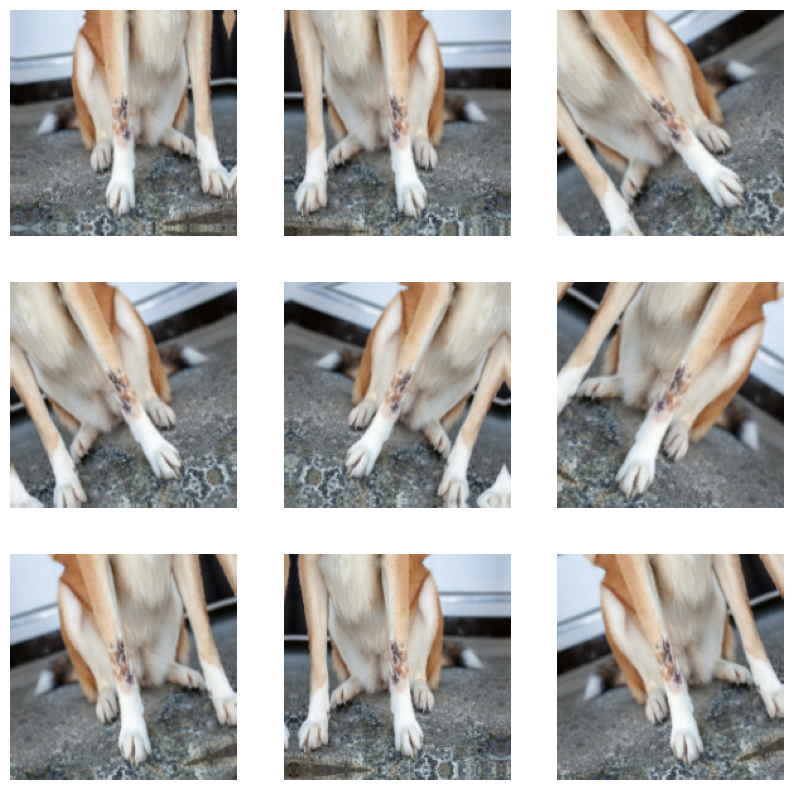

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
     

#Dropout
Another technique to reduce overfitting is to introduce dropout{:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#Compile and train the model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [32]:
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2918 - loss: 2.6175 - val_accuracy: 0.3292 - val_loss: 1.3857
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.1846 - loss: 1.3868 - val_accuracy: 0.2125 - val_loss: 1.3865
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2498 - loss: 1.3863 - val_accuracy: 0.2125 - val_loss: 1.3871
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2912 - loss: 1.3858 - val_accuracy: 0.2125 - val_loss: 1.3880
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2500 - loss: 1.3859 - val_accuracy: 0.2125 - val_loss: 1.3887
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2593 - loss: 1.3859 - val_accuracy: 0.2125 - val_loss: 1.3893
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.2805 - loss: 1.3851 - val_accuracy: 0.2125 - val_loss: 1.3903
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2917 - loss: 1.3839 - val_accuracy: 0.2125 - val_loss:

#Visualize training results
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

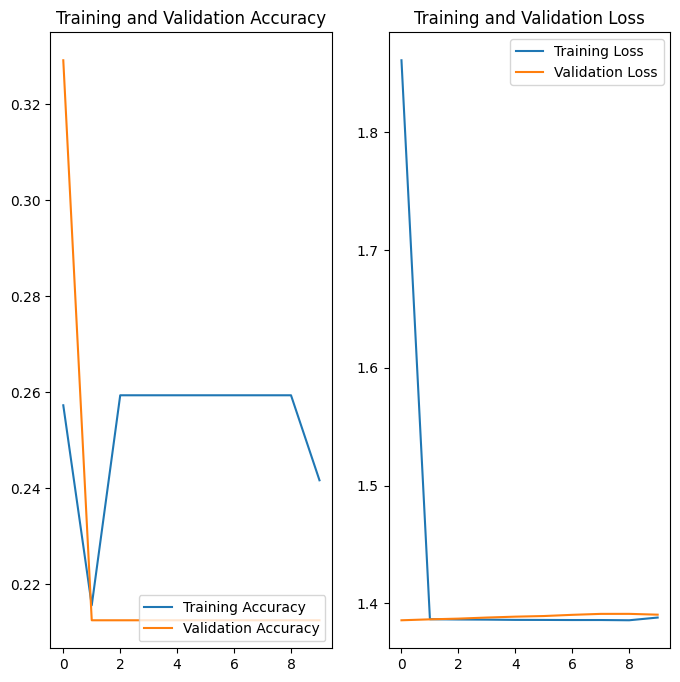

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Predict on new data
Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [36]:
# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET/CLASS_1-FUNGAL_INFECTIONS/121.jpeg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Output the prediction result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
This image most likely belongs to CLASS_4-HEALTHY_SKIN with a 25.53 percent confidence.


Predict on Test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


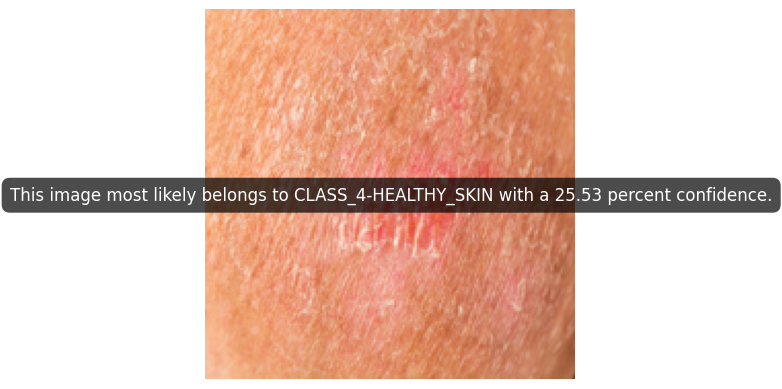

In [37]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET/CLASS_1-FUNGAL_INFECTIONS/121.jpeg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


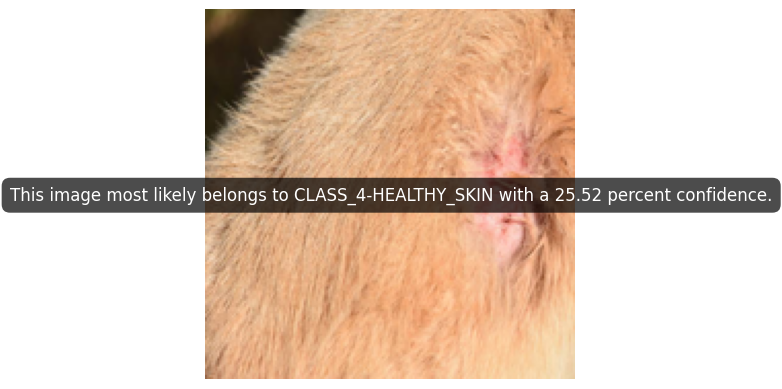

In [38]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET/CLASS_2-BACTERIAL_DERMATOSIS/istockphoto-1072387086-612x612.jpeg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


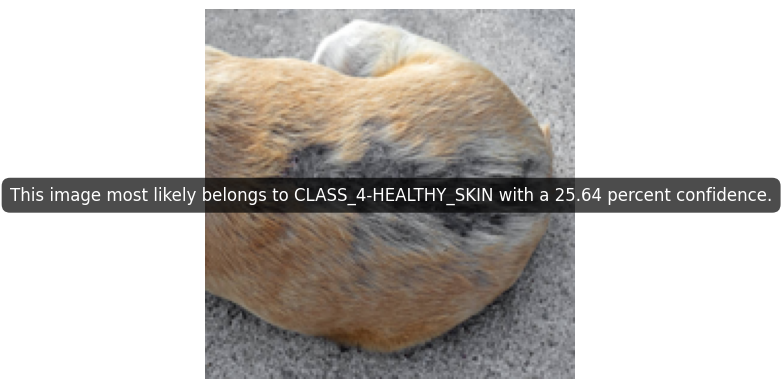

In [39]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET/CLASS_3-HYPERSENSITIVITY_DERMATITIS/istockphoto-904845360-612x612.jpeg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


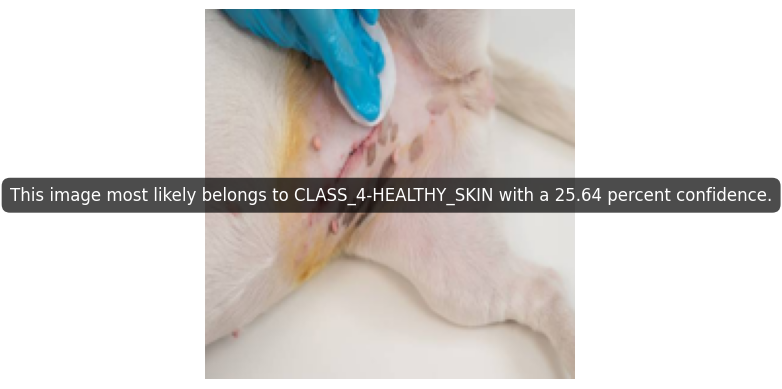

In [40]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/IRIS-KIARA/DATASET/CLASS_3-HYPERSENSITIVITY_DERMATITIS/u7y.jpeg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()